In [1]:
import os
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras

os.listdir("../input/chest-xray-pneumonia/chest_xray")

['chest_xray', '__MACOSX', 'val', 'test', 'train']

In [2]:
len(os.listdir("../input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA"))

3875

The dataset is divided into three sets: 1) Train set 2) Validation set and 3) Test set.

# Data Visualization


Train set:
PNEUMONIA=3875
NORMAL=1341
Test set:
PNEUMONIA=390
NORMAL=234
Validation set:
PNEUMONIA=8
NORMAL=8


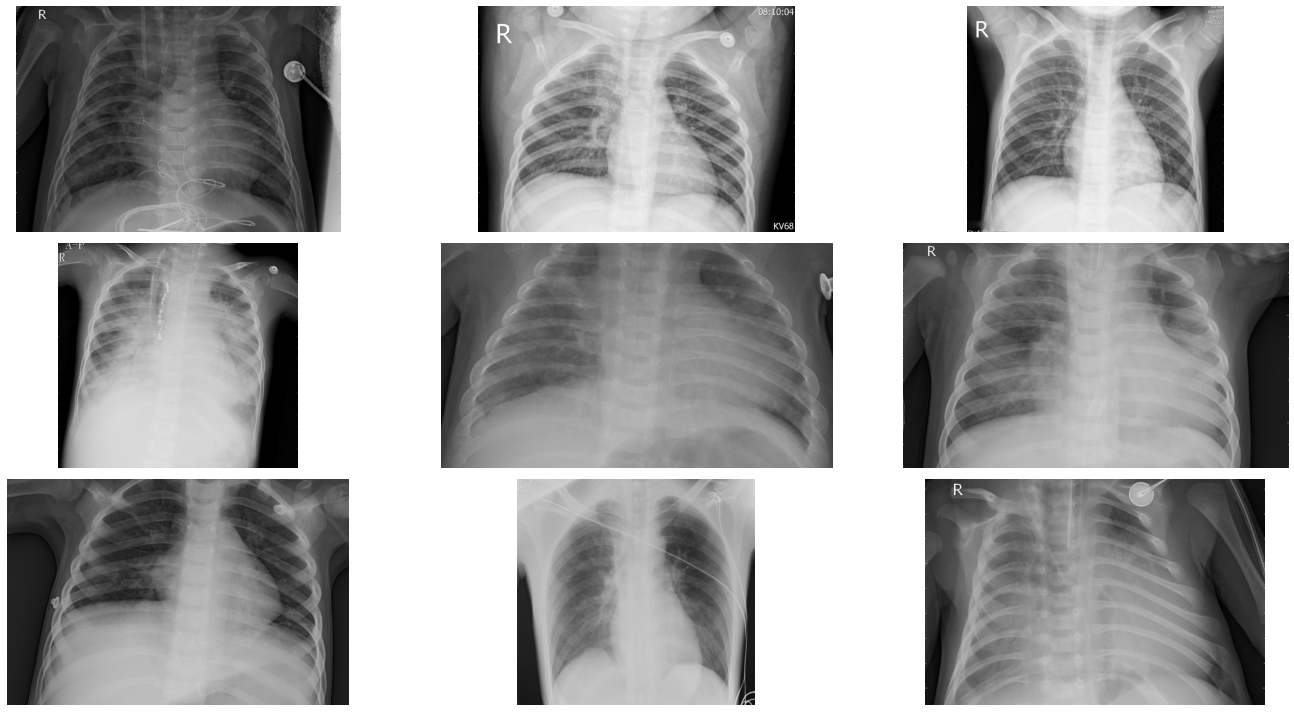

In [3]:
train_dir = "../input/chest-xray-pneumonia/chest_xray/train"
test_dir = "../input/chest-xray-pneumonia/chest_xray/test"
val_dir = "../input/chest-xray-pneumonia/chest_xray/val"

print("Train set:\n========================================")
num_pneumonia = len(os.listdir(os.path.join(train_dir, 'PNEUMONIA')))
num_normal = len(os.listdir(os.path.join(train_dir, 'NORMAL')))
print(f"PNEUMONIA={num_pneumonia}")
print(f"NORMAL={num_normal}")

print("Test set:\n========================================")
print(f"PNEUMONIA={len(os.listdir(os.path.join(test_dir, 'PNEUMONIA')))}")
print(f"NORMAL={len(os.listdir(os.path.join(test_dir, 'NORMAL')))}")

print("Validation set:\n========================================")
print(f"PNEUMONIA={len(os.listdir(os.path.join(val_dir, 'PNEUMONIA')))}")
print(f"NORMAL={len(os.listdir(os.path.join(val_dir, 'NORMAL')))}")

pneumonia = os.listdir("../input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA")
pneumonia_dir = "../input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA"

plt.figure(figsize=(20, 10))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = plt.imread(os.path.join(pneumonia_dir, pneumonia[i]))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    
plt.tight_layout()

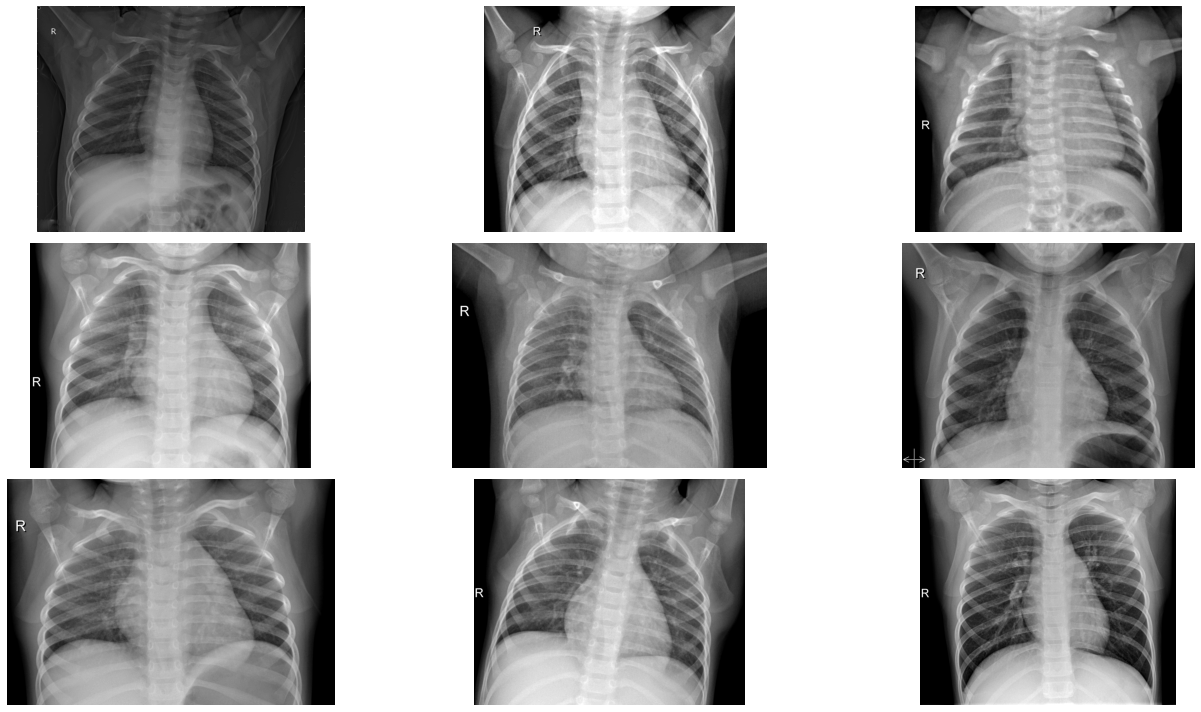

In [4]:
normal = os.listdir("../input/chest-xray-pneumonia/chest_xray/train/NORMAL")
normal_dir = "../input/chest-xray-pneumonia/chest_xray/train/NORMAL"

plt.figure(figsize=(20, 10))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = plt.imread(os.path.join(normal_dir, normal[i]))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    
plt.tight_layout()

The dimensions of the image are 1128 pixels width and 1336 pixels height, one single color channel.
The maximum pixel value is 255.0000 and the minimum is 0.0000
The mean value of the pixels is 73.2978 and the standard deviation is 38.1653


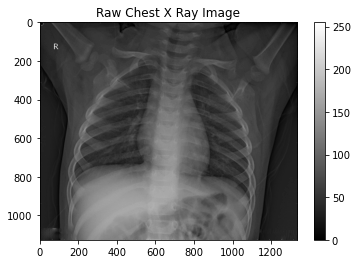

In [5]:
normal_img = os.listdir("../input/chest-xray-pneumonia/chest_xray/train/NORMAL")[0]
normal_dir = "../input/chest-xray-pneumonia/chest_xray/train/NORMAL"
sample_img = plt.imread(os.path.join(normal_dir, normal_img))
plt.imshow(sample_img, cmap='gray')
plt.colorbar()
plt.title('Raw Chest X Ray Image')

print(f"The dimensions of the image are {sample_img.shape[0]} pixels width and {sample_img.shape[1]} pixels height, one single color channel.")
print(f"The maximum pixel value is {sample_img.max():.4f} and the minimum is {sample_img.min():.4f}")
print(f"The mean value of the pixels is {sample_img.mean():.4f} and the standard deviation is {sample_img.std():.4f}")

# Investigate pixel value distribution

Text(0, 0.5, '# Pixels in Image')

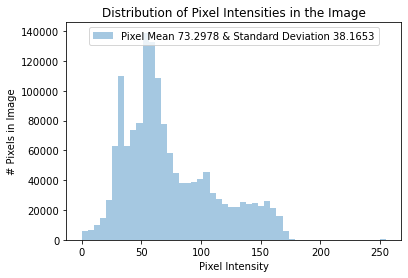

In [6]:
sns.distplot(sample_img.ravel(),
            label=f"Pixel Mean {np.mean(sample_img):.4f} & Standard Deviation {np.std(sample_img):.4f}", kde=False)
plt.legend(loc='upper center')
plt.title('Distribution of Pixel Intensities in the Image')
plt.xlabel('Pixel Intensity')
plt.ylabel('# Pixels in Image')

# 2. Image Preprocessing

In [7]:
from keras.preprocessing.image import ImageDataGenerator

image_generator = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    samplewise_center=True,
    samplewise_std_normalization=True
)

# Build a separate generator fo valid and test sets

In [8]:
train = image_generator.flow_from_directory(train_dir, 
                                            batch_size=8, 
                                            shuffle=True, 
                                            class_mode='binary',
                                            target_size=(180, 180))

validation = image_generator.flow_from_directory(val_dir, 
                                                batch_size=1, 
                                                shuffle=False, 
                                                class_mode='binary',
                                                target_size=(180, 180))

test = image_generator.flow_from_directory(test_dir, 
                                            batch_size=1, 
                                            shuffle=False, 
                                            class_mode='binary',
                                            target_size=(180, 180))

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


The dimensions of the image are 180 pixels width and 180 pixels height, one single color channel.
The maximum pixel value is 2.3323 and the minimum is -4.0538
The mean value of the pixels is -0.0000 and the standard deviation is 1.0000


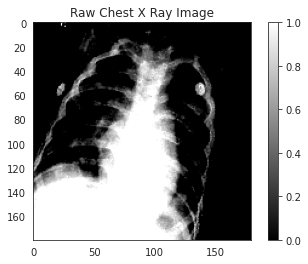

In [9]:
sns.set_style('white')
generated_image, label = train.__getitem__(0)
plt.imshow(generated_image[0], cmap='gray')
plt.colorbar()
plt.title('Raw Chest X Ray Image')

print(f"The dimensions of the image are {generated_image.shape[1]} pixels width and {generated_image.shape[2]} pixels height, one single color channel.")
print(f"The maximum pixel value is {generated_image.max():.4f} and the minimum is {generated_image.min():.4f}")
print(f"The mean value of the pixels is {generated_image.mean():.4f} and the standard deviation is {generated_image.std():.4f}")

Text(0, 0.5, '# Pixels in Image')

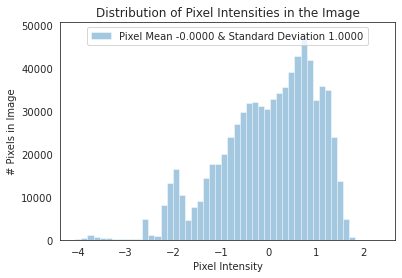

In [10]:
sns.distplot(generated_image.ravel(),
            label=f"Pixel Mean {np.mean(generated_image):.4f} & Standard Deviation {np.std(generated_image):.4f}", kde=False)
plt.legend(loc='upper center')
plt.title('Distribution of Pixel Intensities in the Image')
plt.xlabel('Pixel Intensity')
plt.ylabel('# Pixels in Image')

# Building a CNN model

In [11]:
# Class weights

weight_for_0 = num_pneumonia / (num_normal + num_pneumonia)
weight_for_1 = num_normal / (num_normal + num_pneumonia)

class_weight = {0: weight_for_0, 1: weight_for_1}

print(f"Weight for class 0: {weight_for_0:.2f}")
print(f"Weight for class 1: {weight_for_1:.2f}")

Weight for class 0: 0.74
Weight for class 1: 0.26


In [17]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Dropout, Flatten, BatchNormalization


model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=(180, 180, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=(180, 180, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

In [18]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 178, 178, 32)      896       
_________________________________________________________________
batch_normalization_6 (Batch (None, 178, 178, 32)      128       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 176, 176, 32)      9248      
_________________________________________________________________
batch_normalization_7 (Batch (None, 176, 176, 32)      128       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 88, 88, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 86, 86, 64)        18496     
_________________________________________________________________
batch_normalization_8 (Batch (None, 86, 86, 64)       

In [19]:
r = model.fit(
    train, 
    epochs=25,
    validation_data=validation, 
    class_weight=class_weight,
    steps_per_epoch=100,
    validation_steps=25,
)

Epoch 1/25
100/100 [==============================] - 14s 142ms/step - loss: 0.9961 - accuracy: 0.7763 - val_loss: 42.6123 - val_accuracy: 0.5000
Epoch 2/25
100/100 [==============================] - 14s 144ms/step - loss: 0.3202 - accuracy: 0.8338 - val_loss: 31.1787 - val_accuracy: 0.5000
Epoch 3/25
100/100 [==============================] - 13s 134ms/step - loss: 0.2063 - accuracy: 0.8338 - val_loss: 53.5451 - val_accuracy: 0.5000
Epoch 4/25
100/100 [==============================] - 14s 140ms/step - loss: 0.1550 - accuracy: 0.8737 - val_loss: 2.9550 - val_accuracy: 0.5625
Epoch 5/25
100/100 [==============================] - 14s 139ms/step - loss: 0.1180 - accuracy: 0.8863 - val_loss: 16.0407 - val_accuracy: 0.6250
Epoch 6/25
100/100 [==============================] - 14s 143ms/step - loss: 0.1251 - accuracy: 0.8875 - val_loss: 8.6619 - val_accuracy: 0.5625
Epoch 7/25
100/100 [==============================] - 14s 138ms/step - loss: 0.1262 - accuracy: 0.8813 - val_loss: 0.4831 - va

Text(0.5, 1.0, 'Accuracy Evolution')

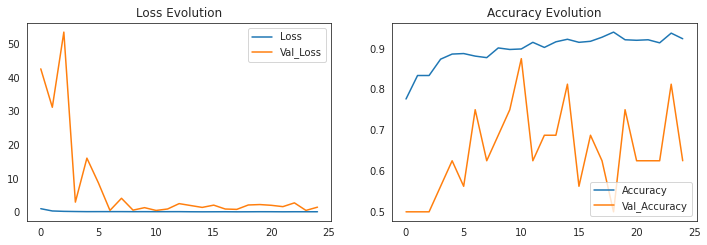

In [20]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(r.history['loss'], label='Loss')
plt.plot(r.history['val_loss'], label='Val_Loss')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(2, 2, 2)
plt.plot(r.history['accuracy'], label='Accuracy')
plt.plot(r.history['val_accuracy'], label='Val_Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

In [21]:
evaluation = model.evaluate(test)
print(f"Test Accuracy: {evaluation[1] * 100:.2f}%")

evaluation = model.evaluate(train)
print(f"Train Accuracy: {evaluation[1] * 100:.2f}%")

624/624 [==============================] - 10s 16ms/step - loss: 0.9715 - accuracy: 0.7436
Test Accuracy: 74.36%
652/652 [==============================] - 85s 130ms/step - loss: 0.1683 - accuracy: 0.9411
Train Accuracy: 94.11%


In [22]:
from sklearn.metrics import confusion_matrix, classification_report

pred = model.predict(test)

print(confusion_matrix(test.classes, pred > 0.5))
pd.DataFrame(classification_report(test.classes, pred > 0.5, output_dict=True))

[[ 69 165]
 [  4 386]]


,0,1,accuracy,macro avg,weighted avg
precision,0.945205,0.700544,0.729167,0.822875,0.792292
recall,0.294872,0.989744,0.729167,0.642308,0.729167
f1-score,0.449511,0.820404,0.729167,0.634958,0.681319
support,234.000000,390.000000,0.729167,624.000000,624.000000


In [23]:
print(confusion_matrix(test.classes, pred > 0.7))
pd.DataFrame(classification_report(test.classes, pred > 0.7, output_dict=True))

[[100 134]
 [ 12 378]]


,0,1,accuracy,macro avg,weighted avg
precision,0.892857,0.738281,0.766026,0.815569,0.796247
recall,0.427350,0.969231,0.766026,0.698291,0.766026
f1-score,0.578035,0.838137,0.766026,0.708086,0.740599
support,234.000000,390.000000,0.766026,624.000000,624.000000


# Transfer Learning
# DenseNet
Densenet is a convolutional network where each layer is connected to all other layers that are deeper in the network:

* The first layer is connected to the 2nd, 3rd, 4th etc.
* The second layer is conected to the 3rd, 4th, 5th etc.

In [24]:
from keras.applications.densenet import DenseNet121
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras import backend as K

base_model = DenseNet121(input_shape=(180, 180, 3), include_top=False, weights='imagenet', pooling='avg')

base_model.summary()

29089792/29084464 [==============================] - 0s 0us/step
Model: "densenet121"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 180, 180, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 186, 186, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 90, 90, 64)   9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 90, 90, 64)   256         conv1/conv[0][0]                 
_______________________

In [25]:
layers = base_model.layers
print(f"The model has {len(layers)} layers")

The model has 428 layers


In [26]:
base_model = DenseNet121(include_top=False, weights='imagenet')
x = base_model.output

x = GlobalAveragePooling2D()(x)

predictions = Dense(1, activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

In [27]:
r = model.fit(
    train, 
    epochs=25,
    validation_data=validation,
    class_weight=class_weight,
    steps_per_epoch=100,
    validation_steps=25,
)

Epoch 1/25
100/100 [==============================] - 17s 166ms/step - loss: 0.1552 - accuracy: 0.8450 - val_loss: 14.7947 - val_accuracy: 0.5000
Epoch 2/25
100/100 [==============================] - 14s 137ms/step - loss: 0.1230 - accuracy: 0.8800 - val_loss: 3.9225 - val_accuracy: 0.5000
Epoch 3/25
100/100 [==============================] - 14s 144ms/step - loss: 0.1120 - accuracy: 0.8750 - val_loss: 2.3616 - val_accuracy: 0.6250
Epoch 4/25
100/100 [==============================] - 14s 141ms/step - loss: 0.1111 - accuracy: 0.8813 - val_loss: 0.9014 - val_accuracy: 0.5000
Epoch 5/25
100/100 [==============================] - 14s 140ms/step - loss: 0.0971 - accuracy: 0.8988 - val_loss: 0.6818 - val_accuracy: 0.6250
Epoch 6/25
100/100 [==============================] - 14s 136ms/step - loss: 0.0857 - accuracy: 0.9162 - val_loss: 0.6553 - val_accuracy: 0.6250
Epoch 7/25
100/100 [==============================] - 14s 140ms/step - loss: 0.1148 - accuracy: 0.8725 - val_loss: 0.9542 - val_a

Text(0.5, 1.0, 'Accuracy Evolution')

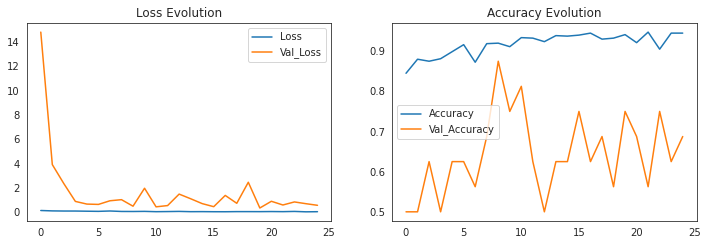

In [28]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(r.history['loss'], label='Loss')
plt.plot(r.history['val_loss'], label='Val_Loss')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(2, 2, 2)
plt.plot(r.history['accuracy'], label='Accuracy')
plt.plot(r.history['val_accuracy'], label='Val_Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

In [29]:
evaluation = model.evaluate(test)
print(f"Test Accuracy: {evaluation[1] * 100:.2f}%")

evaluation = model.evaluate(train)
print(f"Train Accuracy: {evaluation[1] * 100:.2f}%")

624/624 [==============================] - 11s 18ms/step - loss: 0.3212 - accuracy: 0.8942
Test Accuracy: 89.42%
652/652 [==============================] - 86s 132ms/step - loss: 0.3670 - accuracy: 0.8664
Train Accuracy: 86.64%


# Evaluation

In [30]:
predicted_vals = model.predict(test, steps=len(test))

In [31]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [32]:
print(confusion_matrix(test.classes, predicted_vals > 0.7))
pd.DataFrame(classification_report(test.classes, predicted_vals > 0.7, output_dict=True))

[[210  24]
 [ 57 333]]


,0,1,accuracy,macro avg,weighted avg
precision,0.786517,0.932773,0.870192,0.859645,0.877927
recall,0.897436,0.853846,0.870192,0.875641,0.870192
f1-score,0.838323,0.891566,0.870192,0.864945,0.871600
support,234.000000,390.000000,0.870192,624.000000,624.000000
